In [1]:
# Check om alt er nødvendigt her...

import os
import cv2
from iptcinfo3 import IPTCInfo
from PIL import Image, IptcImagePlugin
import re
import zipfile
import shutil
import numpy as np
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# linux location:
linux_dir1raw = '/home/xpn381/data/johan_test1/raw/'
linux_dir1edit = '/home/xpn381/data/johan_test1/edit/'
linux_dir2 = '/home/xpn381/data/johan_test2/'

# get_city_imgs

In [4]:
def get_city_imgs(linux_dir):
    city_imgs = [] # list of images with city in them:
    city_info = (2, 90)

    for img in os.listdir(linux_dir2):
        img_path = os.path.join(linux_dir2, img)

        im = Image.open(img_path)
        info = IptcImagePlugin.getiptcinfo(im)

        if info != None:
            if city_info in info.keys(): 
                city_imgs.append(img_path)

            else:
                pass
            
    return(city_imgs)

In [5]:
# and those you now want date and time from:
# NOPE! you want to tjek city vs discription - men det bliver kun elevant hvis der er rigtigt mange billeder i edit..

# Make city_imgs list and df

In [6]:
def make_city_df(linux_dir):

    city_imgs = get_city_imgs(linux_dir)

    city_info = (2, 90)
    date_info = (2, 55)
    time_info = (2, 60)

    np.random.seed(2015)
    data = []

    for img_path in city_imgs:
        im = Image.open(img_path)
        info = IptcImagePlugin.getiptcinfo(im) 

        img_id = img_path
        city = info[city_info].decode("utf-8")
        date = int(info[date_info].decode("utf-8"))
        time = int(info[time_info].decode("utf-8")[:-5]) # er det sidste tidszoner og kan det bruges til noget?
        
        data.append({'id':img_id,'city': city, 'date':date, 'time':time})

    df = pd.DataFrame(data)
    
    df['stand_date'] = (df['date']-df['date'].mean())/df['date'].std()
    df['stand_time'] = (df['time']-df['time'].mean())/df['time'].std()
    
    df['norm_date'] = (df['date']-df['date'].min())/(df['date'].max() - df['date'].min())
    df['norm_time'] = (df['time']-df['time'].min())/(df['time'].max() - df['time'].min())
    
    return(df, city_imgs)

In [7]:
df, city_imgs = make_city_df(linux_dir2)

In [22]:
df.head()

,id,city,date,time,stand_date,stand_time,norm_date,norm_time
0,/home/xpn381/data/johan_test2/1568884391729434...,Kirkuk,20090929,103508,-0.733098,-1.215883,0.0,0.104414
1,/home/xpn381/data/johan_test2/1568884391729925...,Kirkuk,20090929,103537,-0.733098,-1.214838,0.0,0.104779
2,/home/xpn381/data/johan_test2/1568884391730428...,Kirkuk,20090929,103943,-0.733098,-1.200210,0.0,0.109883
3,/home/xpn381/data/johan_test2/1568884391730990...,Kirkuk,20090929,104021,-0.733098,-1.197400,0.0,0.110864
4,/home/xpn381/data/johan_test2/1568884391732055...,Kirkuk,20090929,104726,-0.733098,-1.171999,0.0,0.119727


In [8]:
df.describe()

,date,time,stand_date,stand_time,norm_date,norm_time
count,6.800000e+01,68.000000,6.800000e+01,6.800000e+01,68.000000,68.000000
mean,2.009093e+07,137255.220588,-2.731004e-09,-2.612289e-16,0.352941,0.528699
std,4.814377e-01,27755.329156,1.000000e+00,1.000000e+00,0.481438,0.348952
min,2.009093e+07,95203.000000,-7.330983e-01,-1.515104e+00,0.000000,0.000000
25%,2.009093e+07,110786.250000,-7.330983e-01,-9.536536e-01,0.000000,0.195920
50%,2.009093e+07,135607.000000,-7.330983e-01,-5.938393e-02,0.000000,0.507977
75%,2.009093e+07,172561.250000,1.344014e+00,1.272045e+00,1.000000,0.972583
max,2.009093e+07,174742.000000,1.344014e+00,1.350616e+00,1.000000,1.000000


In [9]:
print(df[df['city'] == 'Baghdad'].shape[0])
print(df[df['city'] != 'Baghdad'].shape[0])

18
50


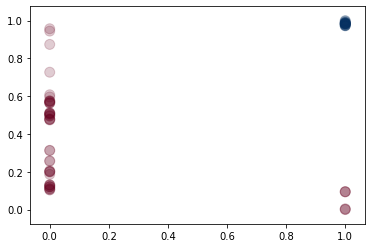

In [10]:
city_dum = (df['city'] == df['city'][0])*1 
plt.scatter(df['norm_date'], df['norm_time'], s = 100, c = city_dum, cmap =plt.cm.RdBu_r, alpha = 0.2)
plt.show()

# Extract dates and time for those that misses

Maybe.. If need be

# Just do it for all thos with IPCT until you know if it is an issue.

In [11]:
def get_no_city_imgs(linux_dir):

    date_info = (2, 55)
    time_info = (2, 60)

    no_city_imgs = []

    for img in os.listdir(linux_dir):
        img_path = os.path.join(linux_dir, img)
        im = Image.open(img_path)
        info = IptcImagePlugin.getiptcinfo(im)

        if time_info in list(info.keys()) and date_info in list(info.keys()):
            no_city_imgs.append(img_path)

            
    return(no_city_imgs)

In [12]:
# no_city_imgs = get_no_city_imgs(linux_dir2)

# Training model:
put shit into functions fukface,

In [13]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [14]:
# clf = SVC(kernel='rbf', gamma='auto', probability=True)
clf = SVC(kernel='rbf', gamma=10, probability=True)

X = df[['norm_date','norm_time']]
y = df['city']

# clf.fit(X_train, y_train)
clf.fit(X, y)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [15]:
print(f"Predicted city (insample): {clf.predict(np.array(df[['norm_date','norm_time']].iloc[0]).reshape(1,-1))[0]}")
print(f"Prob of predicted city: {np.max(clf.predict_proba(np.array(df[['date','norm_time']].iloc[0]).reshape(1,-1))):.2}")
print(f"True city: {df['city'].iloc[0]}")

Predicted city (insample): Kirkuk
Prob of predicted city: 0.92
True city: Kirkuk


In [16]:
print(f"Predicted city (insample): {clf.predict(np.array(df[['norm_date','norm_time']].iloc[-1]).reshape(1,-1))[0]}")
print(f"Prob of predicted city: {np.max(clf.predict_proba(np.array(df[['norm_date','norm_time']].iloc[-1]).reshape(1,-1))):.2}")
print(df['city'].iloc[-1])

Predicted city (insample): Baghdad
Prob of predicted city: 0.95
Baghdad


Text(0.5, 1.0, 'SVM RBF')

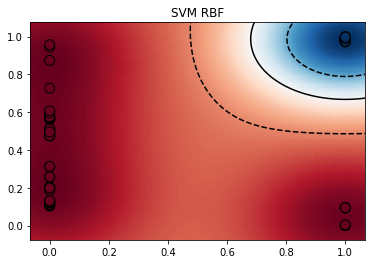

In [17]:
plt.figure()
plt.clf()
plt.scatter(df['norm_date'], df['norm_time'], c=city_dum, zorder=10, cmap=plt.cm.RdBu_r, s=100, edgecolor='k')
# plt.scatter(df['norm_date'], df['norm_time'], c=city_dum, zorder=10, cmap=plt.cm.Paired, s=100, edgecolor='k')  #with the binary colors


    # Circle out the test data
#     plt.scatter(X_test[:, 0], X_test[:, 1], s=80, facecolors='none', zorder=10)

plt.axis('tight')

x_min = df['norm_date'].min() - 0.1 # 0.1 just to fill the whole plot...
x_max = df['norm_date'].max() + 0.1
y_min = df['norm_time'].min() - 0.1
y_max = df['norm_time'].max() + 0.1

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

# Put the result into a color plot
Z = Z.reshape(XX.shape)
# plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired) #binary: also works fine
plt.pcolormesh(XX, YY, Z, cmap= plt.cm.RdBu_r)  

plt.contour(XX, YY, Z, colors=['k', 'k', 'k'],linestyles=['--', '-', '--'], levels=[-.5, 0, .5])

plt.title('SVM RBF')

### Need a bit more data to make it out-of-sample

# Create no_city_df

In [18]:
def make_no_city_df(linux_dir):

    no_city_imgs = get_no_city_imgs(linux_dir2)

    city_info = (2, 90)
    date_info = (2, 55)
    time_info = (2, 60)

    data = []

    for img_path in no_city_imgs:
            im = Image.open(img_path)
            info = IptcImagePlugin.getiptcinfo(im) 

            img_id = img_path# CHANGE!
            city = None
            date = int(info[date_info].decode("utf-8"))
            time = int(info[time_info].decode("utf-8")[:-5])

            data.append({'id':img_id,'city': city, 'date':date, 'time':time})

    df = pd.DataFrame(data)

    df['stand_date'] = (df['date']-df['date'].mean())/df['date'].std()
    df['stand_time'] = (df['time']-df['time'].mean())/df['time'].std()

    df['norm_date'] = (df['date']-df['date'].min())/(df['date'].max() - df['date'].min())
    df['norm_time'] = (df['time']-df['time'].min())/(df['time'].max() - df['time'].min())
    
    #note:
    # df['city'][0] = 'århus' #WORKS
    
    return(df, city_imgs)

In [19]:
df_pred, no_city_imgs = make_no_city_df(linux_dir2)

In [21]:
df_pred.head()

,id,city,date,time,stand_date,stand_time,norm_date,norm_time
0,/home/xpn381/data/johan_test2/1568884391316826...,None,20090929,135730,-1.557034,-0.290707,0.0,0.613433
1,/home/xpn381/data/johan_test2/1568884391317755...,None,20090929,135740,-1.557034,-0.290410,0.0,0.613478
2,/home/xpn381/data/johan_test2/1568884391319787...,None,20090929,135740,-1.557034,-0.290410,0.0,0.613478
3,/home/xpn381/data/johan_test2/1568884391321799...,None,20090929,135740,-1.557034,-0.290410,0.0,0.613478
4,/home/xpn381/data/johan_test2/1568884391322908...,None,20090929,135749,-1.557034,-0.290144,0.0,0.613520


In [20]:
df_pred.describe()

,date,time,stand_date,stand_time,norm_date,norm_time
count,1.504000e+03,1504.000000,1.504000e+03,1.504000e+03,1504.000000,1504.000000
mean,2.009093e+07,145545.611702,-2.788551e-09,-4.015700e-16,0.708112,0.658435
std,4.547824e-01,33764.672104,1.000000e+00,1.000000e+00,0.454782,0.154804
min,2.009093e+07,1933.000000,-1.557034e+00,-4.253339e+00,0.000000,0.000000
25%,2.009093e+07,140028.000000,-1.557034e+00,-1.634138e-01,0.000000,0.633138
50%,2.009093e+07,143754.000000,6.418197e-01,-5.306172e-02,1.000000,0.650221
75%,2.009093e+07,173170.000000,6.418197e-01,8.181447e-01,1.000000,0.785087
max,2.009093e+07,220045.000000,6.418197e-01,2.206430e+00,1.000000,1.000000


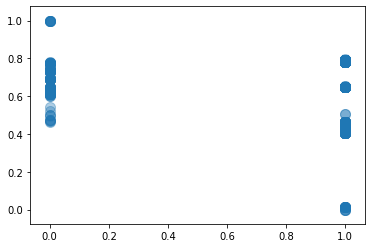

In [23]:
plt.scatter(df_pred['norm_date'], df_pred['norm_time'], s = 100, alpha = 0.2)
plt.show()

# Prediction:
 so now you find the date and time for all other images in the folder and then predict:

In [38]:
df_pred['city'] = clf.predict(df_pred[['norm_date', 'norm_time']])
pred_probs = clf.predict_proba(df_pred[['norm_date', 'norm_time']])

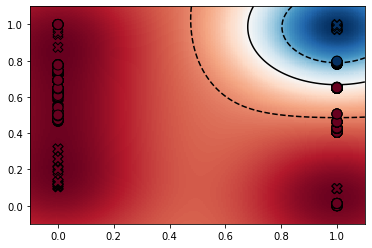

In [54]:
city_dum = (df_pred['city'] == df_pred['city'][0])*1 
city_dum1 = (df['city'] == df['city'][0])*1 


# plt.scatter(df['norm_date'], df['norm_time'], c=city_dum, zorder=10, cmap=plt.cm.RdBu_r, s=100, edgecolor=k)

plt.scatter(df['norm_date'], df['norm_time'], c=city_dum1, zorder=10, cmap=plt.cm.RdBu_r, s=100, edgecolor='k', marker= 'X')
plt.scatter(df_pred['norm_date'], df_pred['norm_time'], c=city_dum, zorder=10, cmap=plt.cm.RdBu_r, s=100, edgecolor='k')


x_min = df_pred['norm_date'].min() - 0.1 # 0.1 just to fill the whole plot...
x_max = df_pred['norm_date'].max() + 0.1
y_min = df_pred['norm_time'].min() - 0.1
y_max = df_pred['norm_time'].max() + 0.1

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
Z = Z.reshape(XX.shape)

plt.pcolormesh(XX, YY, Z, cmap= plt.cm.RdBu_r)  

plt.contour(XX, YY, Z, colors=['k', 'k', 'k'],linestyles=['--', '-', '--'], levels=[-.5, 0, .5])

plt.show()

In [66]:
max_probs = np.max(pred_probs, 1)
max_probs[max_probs < 0.67] # 0.67 lowest prop with obs.
# så du kan bare fjerne dem med stor usikkerhed hvis i er utrykke.
# du kan også sætte usikkerheden in i IPTCen som in var så du har den senere..

array([0.66221506, 0.66220245, 0.66220245, 0.66220245, 0.66983666,
       0.66983666, 0.66966344, 0.66963869, 0.66963869, 0.66961394,
       0.66960156, 0.66960156, 0.66956443, 0.66956443, 0.66956443,
       0.66955205, 0.66955205, 0.66955205, 0.66953967, 0.66953967,
       0.66946538, 0.66946538, 0.669453  , 0.669453  , 0.669453  ,
       0.66927961, 0.66925483, 0.66925483, 0.66924244, 0.66923005,
       0.66870932, 0.66869691, 0.66983666, 0.66983666, 0.66966344,
       0.66963869, 0.66963869, 0.66961394, 0.66960156, 0.66960156,
       0.66956443, 0.66956443, 0.66956443, 0.66955205, 0.66955205,
       0.66955205, 0.66953967, 0.66953967, 0.66946538, 0.66946538,
       0.669453  , 0.669453  , 0.669453  , 0.66927961, 0.66925483,
       0.66925483, 0.66924244, 0.66923005, 0.66870932, 0.66869691])

# get city back tp IPCT protocol:

# first 
Need reiterate through all img with IPTC and check/correct city/location. Do this by looking in describtion maybe using a list of town names and  Fuzzy String Matching (see https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ and here https://towardsdatascience.com/natural-language-processing-for-fuzzy-string-matching-with-python-6632b7824c49) ...


# then
now, you need to reiterate through all the images and sort for images with IPTC.. from these you need to get date, time and not least place!

pseudo code:  

for images in dir:  
    if image.IPTC exist:  
        date = image.IPTC.date  
        time = image.IPTC.time  
        city = image.IPTC.city  
        owner = image.IPTC.copyright  
           
  
        then....  
        You make a dict holding time, date, locale and some image id.. This dict is then converted into a pandas dataframe (see https://stackoverflow.com/questions/18837262/convert-python-dict-into-a-dataframe)   

        with this dataframe you should be able to classify - either hard-code or via e.g k-nearest neighbor - the raw (no IPTC) images. 
        also you need here to consider transport images..  

# old:


- Reiterate through IPTC images getting date and location.
- Also get first and last time for said date to remove "transport" images. (see if that solves it..)
- Now, for each 'i' in w_IPTC  reiterate through each 'j' in no_IPTC matching on date and interpolating locale if time is between first and last in w_IPCT.

....